In [1]:
pip install -U scikit-learn imbalanced-learn pandas numpy matplotlib seaborn xgboost lightgbm shap

Note: you may need to restart the kernel to use updated packages.


# Import Libraries

In [2]:
# Data manipulation and analysis
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# Preprocessing and model selection
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score, 
    precision_recall_curve, auc, roc_curve, average_precision_score
)

# Imbalance handling
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, IsolationForest
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# Explainability
import shap

# Settings
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')
pd.set_option('display.max_columns', None)

# Reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# Load Dataset

In [3]:
df = pd.read_csv('creditcard.csv')

print("Dataset Shape:", df.shape)
print("\nFirst 5 rows:")
df.head()

Dataset Shape: (284807, 31)

First 5 rows:


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


# Dataset info

In [4]:
print("Dataset Information:")
print("="*50)
df.info()

print("\n" + "="*50)
print("Missing Values:")
print(df.isnull().sum().sum(), "total missing values")

print("\n" + "="*50)
print("Statistical Summary:")
df.describe()

Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  fl

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.175161e-15,3.384974e-16,-1.379537e-15,2.094852e-15,1.021879e-15,1.494498e-15,-5.620335e-16,1.149614e-16,-2.414189e-15,2.238554e-15,1.724421e-15,-1.245415e-15,8.238900e-16,1.213481e-15,4.866699e-15,1.436219e-15,-3.768179e-16,9.707851e-16,1.036249e-15,6.418678e-16,1.628620e-16,-3.576577e-16,2.618565e-16,4.473914e-15,5.109395e-16,1.686100e-15,-3.661401e-16,-1.227452e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,1.088850e+00,1.020713e+00,9.992014e-01,9.952742e-01,9.585956e-01,9.153160e-01,8.762529e-01,8.493371e-01,8.381762e-01,8.140405e-01,7.709250e-01,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,-2.458826e+01,-4.797473e+00,-1.868371e+01,-5.791881e+00,-1.921433e+01,-4.498945e+00,-1.412985e+01,-2.516280e+01,-9.498746e+00,-7.213527e+00,-5.449772e+01,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,-5.354257e-01,-7.624942e-01,-4.055715e-01,-6.485393e-01,-4.255740e-01,-5.828843e-01,-4.680368e-01,-4.837483e-01,-4.988498e-01,-4.562989e-01,-2.117214e-01,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,-9.291738e-02,-3.275735e-02,1.400326e-01,-1.356806e-02,5.060132e-02,4.807155e-02,6.641332e-02,-6.567575e-02,-3.636312e-03,3.734823e-03,-6.248109e-02,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,4.539234e-01,7.395934e-01,6.182380e-01,6.625050e-01,4.931498e-01,6.488208e-01,5.232963e-01,3.996750e-01,5.008067e-01,4.589494e-01,1.330408e-01,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,2.374514e+01,1.201891e+01,7.848392e+00,7.126883e+00,1.052677e+01,8.877742e+00,1.731511e+01,9.253526e+00,5.041069e+00,5.591971e+00,3.942090e+01,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


# Initial Observations

In [5]:
# Class distribution
fraud_count = df['Class'].value_counts()
fraud_percentage = df['Class'].value_counts(normalize=True) * 100

print("Class Distribution:")
print("="*50)
print(f"Legitimate Transactions (0): {fraud_count[0]:,} ({fraud_percentage[0]:.3f}%)")
print(f"Fraudulent Transactions (1): {fraud_count[1]:,} ({fraud_percentage[1]:.3f}%)")
print(f"\nImbalance Ratio: {fraud_count[0]/fraud_count[1]:.1f}:1")
print("\n⚠️ Extreme class imbalance detected - special handling required!")

Class Distribution:
Legitimate Transactions (0): 284,315 (99.827%)
Fraudulent Transactions (1): 492 (0.173%)

Imbalance Ratio: 577.9:1

⚠️ Extreme class imbalance detected - special handling required!


# Exploratory Data Analysis (EDA)
## Target Variable Analysis

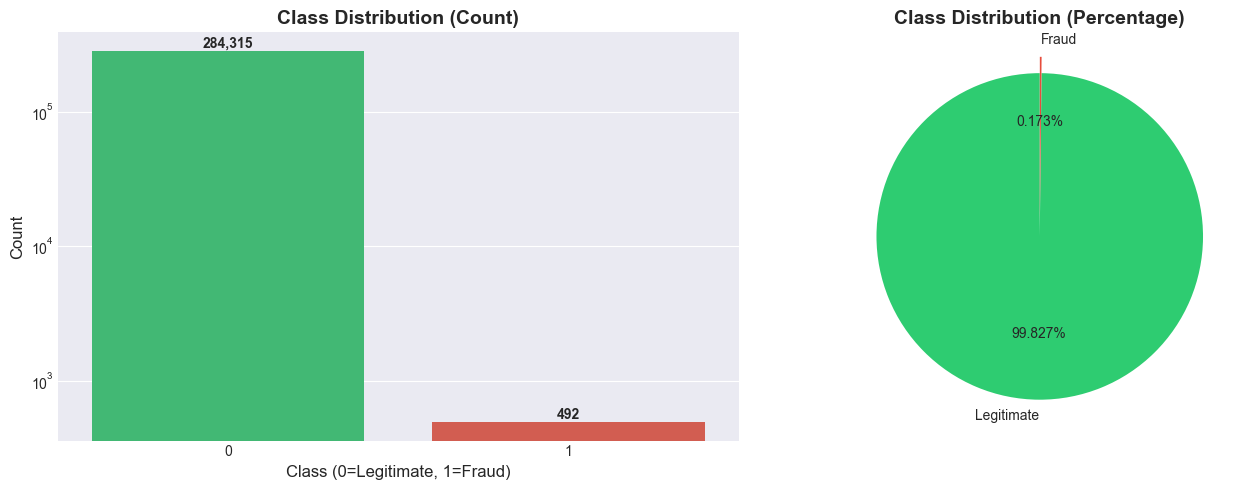

📊 Class imbalance visualization shows the extreme skew in our dataset


In [6]:
# Visualize class imbalance
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Count plot
sns.countplot(data=df, x='Class', ax=axes[0], palette=['#2ecc71', '#e74c3c'])
axes[0].set_title('Class Distribution (Count)', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Class (0=Legitimate, 1=Fraud)', fontsize=12)
axes[0].set_ylabel('Count', fontsize=12)
axes[0].set_yscale('log')
for i, v in enumerate(fraud_count):
    axes[0].text(i, v, f'{v:,}', ha='center', va='bottom', fontweight='bold')

# Percentage plot
colors = ['#2ecc71', '#e74c3c']
axes[1].pie(fraud_count, labels=['Legitimate', 'Fraud'], autopct='%1.3f%%', 
            colors=colors, startangle=90, explode=[0, 0.1])
axes[1].set_title('Class Distribution (Percentage)', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

print("📊 Class imbalance visualization shows the extreme skew in our dataset")

## Feature Exploration

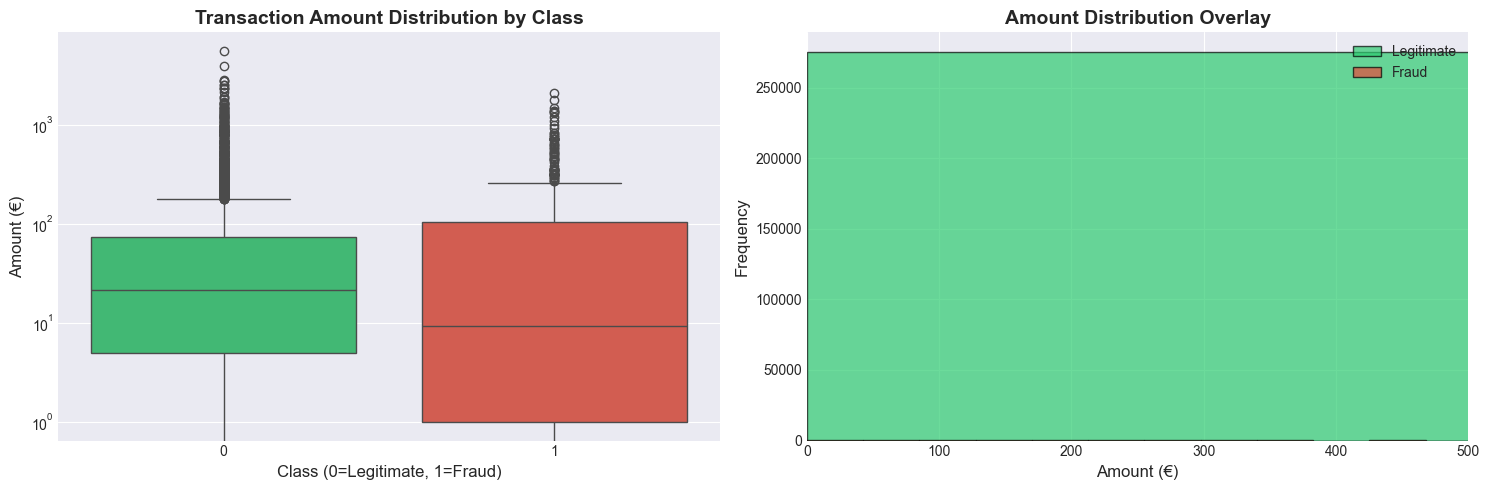


💡 Insight: Fraudulent transactions tend to have lower amounts, but some large frauds exist.


In [7]:
# Amount distribution by class
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Box plot
df_sample = df[df['Class'] == 1].copy()  # All frauds
df_sample = pd.concat([df_sample, df[df['Class'] == 0].sample(n=5000, random_state=RANDOM_STATE)])  # Sample legitimate

sns.boxplot(data=df_sample, x='Class', y='Amount', ax=axes[0], palette=['#2ecc71', '#e74c3c'])
axes[0].set_title('Transaction Amount Distribution by Class', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Class (0=Legitimate, 1=Fraud)', fontsize=12)
axes[0].set_ylabel('Amount (€)', fontsize=12)
axes[0].set_yscale('log')

# Histogram
axes[1].hist(df[df['Class'] == 0]['Amount'], bins=50, alpha=0.7, label='Legitimate', color='#2ecc71', edgecolor='black')
axes[1].hist(df[df['Class'] == 1]['Amount'], bins=50, alpha=0.7, label='Fraud', color='#e74c3c', edgecolor='black')
axes[1].set_title('Amount Distribution Overlay', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Amount (€)', fontsize=12)
axes[1].set_ylabel('Frequency', fontsize=12)
axes[1].legend()
axes[1].set_xlim([0, 500])

plt.tight_layout()
plt.show()

print("\n💡 Insight: Fraudulent transactions tend to have lower amounts, but some large frauds exist.")

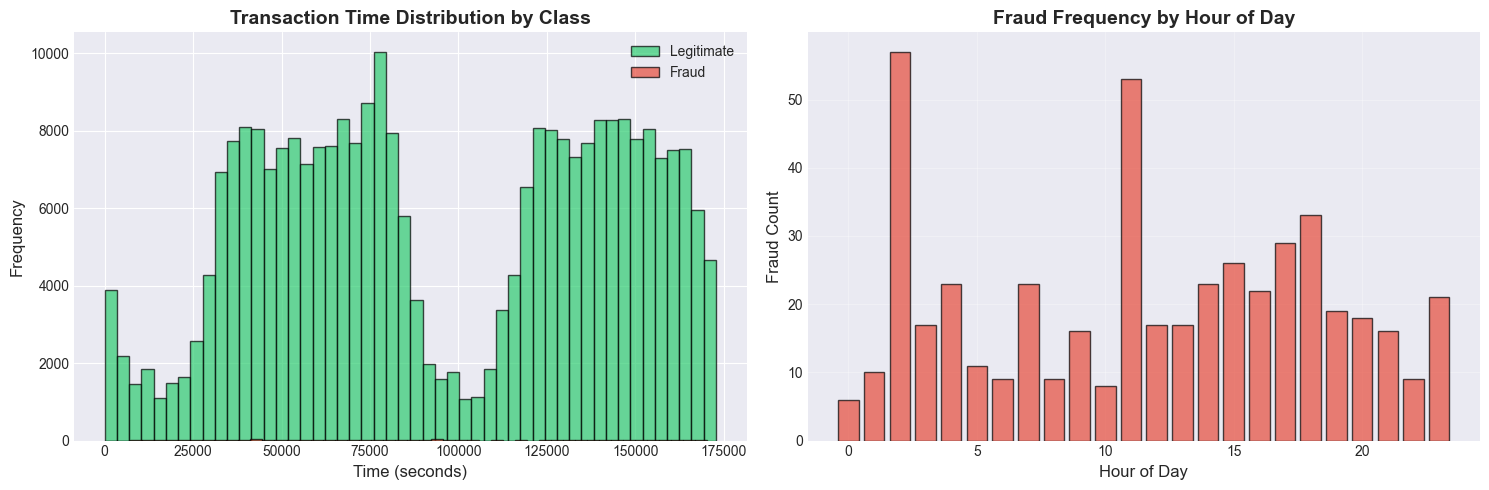


💡 Insight: Fraud patterns may vary by time of day - useful for feature engineering.


In [8]:
# Time distribution analysis
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Time distribution by class
axes[0].hist(df[df['Class'] == 0]['Time'], bins=50, alpha=0.7, label='Legitimate', color='#2ecc71', edgecolor='black')
axes[0].hist(df[df['Class'] == 1]['Time'], bins=50, alpha=0.7, label='Fraud', color='#e74c3c', edgecolor='black')
axes[0].set_title('Transaction Time Distribution by Class', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Time (seconds)', fontsize=12)
axes[0].set_ylabel('Frequency', fontsize=12)
axes[0].legend()

# Time of day analysis (assuming 2 days of data)
df['Hour'] = (df['Time'] % 86400) / 3600  # Convert to hour of day
fraud_by_hour = df[df['Class'] == 1].groupby(df['Hour'].astype(int)).size()
axes[1].bar(fraud_by_hour.index, fraud_by_hour.values, color='#e74c3c', edgecolor='black', alpha=0.7)
axes[1].set_title('Fraud Frequency by Hour of Day', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Hour of Day', fontsize=12)
axes[1].set_ylabel('Fraud Count', fontsize=12)
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Clean up temporary column immediately
df.drop('Hour', axis=1, inplace=True)

print("\n💡 Insight: Fraud patterns may vary by time of day - useful for feature engineering.")

## Correlation Analysis

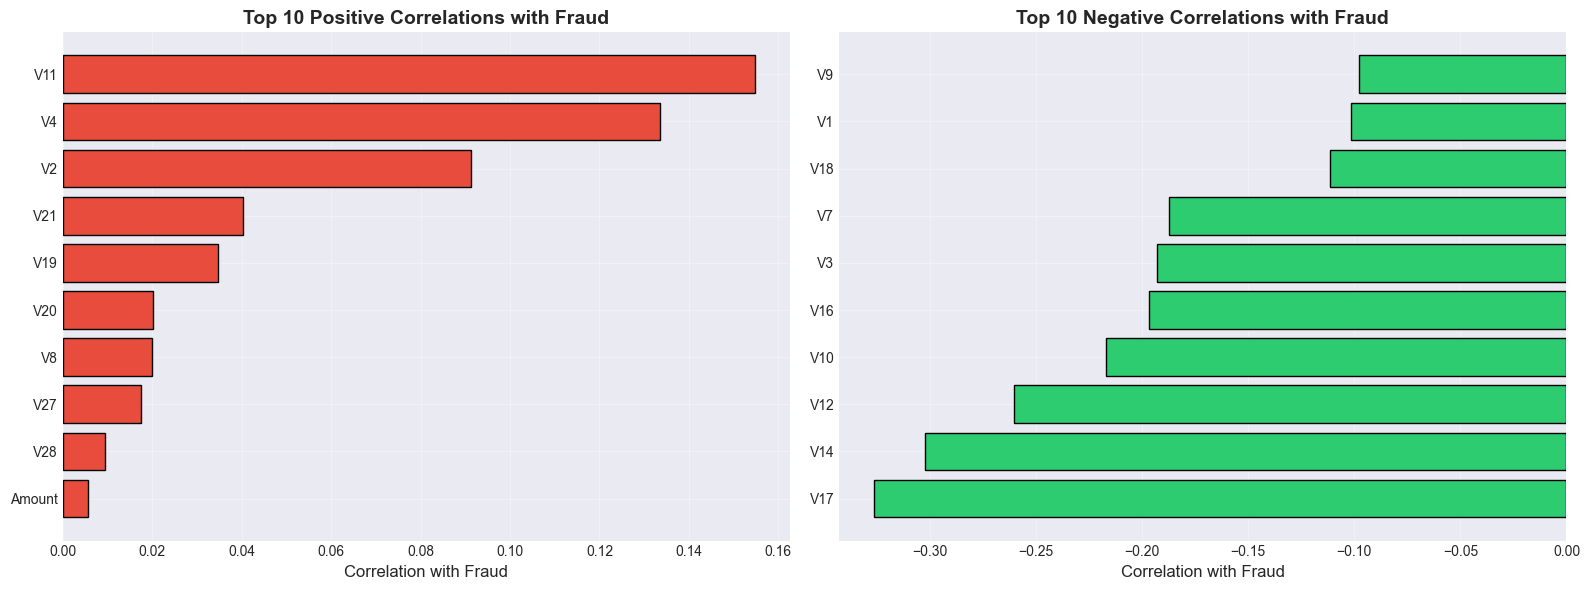


💡 Insight: Several PCA components show strong correlations with fraud.
   Strongest positive: 0.155 (V11)
   Strongest negative: -0.326 (V17)


In [9]:
# Correlation with target variable
correlations = df.corr()['Class'].drop('Class').sort_values(ascending=False)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Top positive correlations
top_positive = correlations.head(10)
axes[0].barh(range(len(top_positive)), top_positive.values, color='#e74c3c', edgecolor='black')
axes[0].set_yticks(range(len(top_positive)))
axes[0].set_yticklabels(top_positive.index)
axes[0].set_xlabel('Correlation with Fraud', fontsize=12)
axes[0].set_title('Top 10 Positive Correlations with Fraud', fontsize=14, fontweight='bold')
axes[0].invert_yaxis()
axes[0].grid(alpha=0.3)

# Top negative correlations
top_negative = correlations.tail(10)
axes[1].barh(range(len(top_negative)), top_negative.values, color='#2ecc71', edgecolor='black')
axes[1].set_yticks(range(len(top_negative)))
axes[1].set_yticklabels(top_negative.index)
axes[1].set_xlabel('Correlation with Fraud', fontsize=12)
axes[1].set_title('Top 10 Negative Correlations with Fraud', fontsize=14, fontweight='bold')
axes[1].invert_yaxis()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("\n💡 Insight: Several PCA components show strong correlations with fraud.")
print(f"   Strongest positive: {correlations.iloc[0]:.3f} ({correlations.index[0]})")
print(f"   Strongest negative: {correlations.iloc[-1]:.3f} ({correlations.index[-1]})")

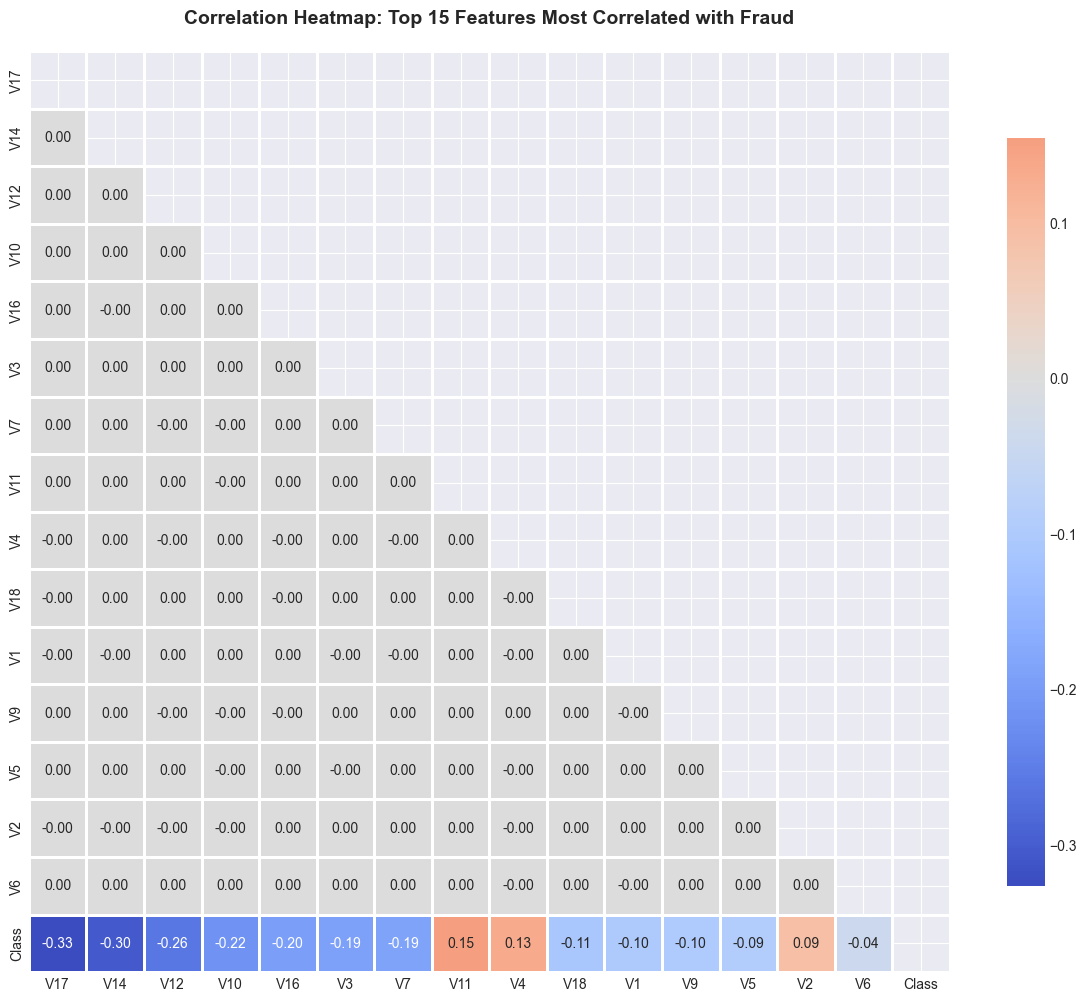


💡 Insight: Limited multicollinearity due to PCA transformation - good for modeling.


In [10]:
# Correlation heatmap (selected features)
# Select most correlated features with fraud
top_features = correlations.abs().sort_values(ascending=False).head(15).index.tolist()
top_features.append('Class')

plt.figure(figsize=(12, 10))
mask = np.triu(np.ones_like(df[top_features].corr(), dtype=bool))
sns.heatmap(df[top_features].corr(), mask=mask, annot=True, fmt='.2f', 
            cmap='coolwarm', center=0, square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Correlation Heatmap: Top 15 Features Most Correlated with Fraud', fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

print("\n💡 Insight: Limited multicollinearity due to PCA transformation - good for modeling.")

# Data Preprocessing

## Feature Engineering

In [11]:
# Drop temporary Hour column if exists
df_processed = df.drop('Hour', axis=1, errors='ignore').copy()

# Separate features and target
X = df_processed.drop('Class', axis=1)
y = df_processed['Class']

print("Feature matrix shape:", X.shape)
print("Target variable shape:", y.shape)
print(f"\nTarget distribution: {y.value_counts().to_dict()}")

Feature matrix shape: (284807, 30)
Target variable shape: (284807,)

Target distribution: {0: 284315, 1: 492}


## Train-Test Split (Stratified)

In [12]:
# Stratified split to maintain class distribution
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
)

print("Training set:")
print(f"  Shape: {X_train.shape}")
print(f"  Fraud cases: {y_train.sum()} ({y_train.sum()/len(y_train)*100:.3f}%)")
print(f"\nTest set:")
print(f"  Shape: {X_test.shape}")
print(f"  Fraud cases: {y_test.sum()} ({y_test.sum()/len(y_test)*100:.3f}%)")
print("\n✅ Stratified split maintains class distribution in both sets")

Training set:
  Shape: (227845, 30)
  Fraud cases: 394 (0.173%)

Test set:
  Shape: (56962, 30)
  Fraud cases: 98 (0.172%)

✅ Stratified split maintains class distribution in both sets


## Feature Scaling

In [13]:
# Scale Time and Amount using RobustScaler (less sensitive to outliers)
scaler = RobustScaler()

# Fit on training data only (using .loc[] to avoid SettingWithCopyWarning)
X_train.loc[:, ['Time', 'Amount']] = scaler.fit_transform(X_train[['Time', 'Amount']])
X_test.loc[:, ['Time', 'Amount']] = scaler.transform(X_test[['Time', 'Amount']])

print("✅ Time and Amount features scaled using RobustScaler")
print("\nScaled feature statistics (training set):")
print(X_train[['Time', 'Amount']].describe())

✅ Time and Amount features scaled using RobustScaler

Scaled feature statistics (training set):
                Time         Amount
count  227845.000000  227845.000000
mean        0.118400       0.921034
std         0.557795       3.489528
min        -0.996112      -0.306193
25%        -0.359155      -0.227697
50%         0.000000       0.000000
75%         0.640845       0.772303
max         1.033488     357.260404


# Handling Class Imbalance

## Baseline: Original Imbalanced Data

In [14]:
print("Original Training Data Distribution:")
print("="*50)
print(f"Legitimate (0): {(y_train == 0).sum():,}")
print(f"Fraud (1): {(y_train == 1).sum():,}")
print(f"Imbalance Ratio: {(y_train == 0).sum() / (y_train == 1).sum():.1f}:1")

Original Training Data Distribution:
Legitimate (0): 227,451
Fraud (1): 394
Imbalance Ratio: 577.3:1


## SMOTE (Synthetic Minority Over-sampling)

In [15]:
# Apply SMOTE
smote = SMOTE(random_state=RANDOM_STATE, k_neighbors=5)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

print("SMOTE Resampled Training Data:")
print("="*50)
print(f"Legitimate (0): {(y_train_smote == 0).sum():,}")
print(f"Fraud (1): {(y_train_smote == 1).sum():,}")
print(f"New Ratio: {(y_train_smote == 0).sum() / (y_train_smote == 1).sum():.1f}:1")
print(f"\n✅ Created {(y_train_smote == 1).sum() - (y_train == 1).sum():,} synthetic fraud examples")

SMOTE Resampled Training Data:
Legitimate (0): 227,451
Fraud (1): 227,451
New Ratio: 1.0:1

✅ Created 227,057 synthetic fraud examples


## Random Undersampling

In [16]:
# Apply Random Undersampling
rus = RandomUnderSampler(random_state=RANDOM_STATE)
X_train_rus, y_train_rus = rus.fit_resample(X_train, y_train)

print("Undersampled Training Data:")
print("="*50)
print(f"Legitimate (0): {(y_train_rus == 0).sum():,}")
print(f"Fraud (1): {(y_train_rus == 1).sum():,}")
print(f"New Ratio: {(y_train_rus == 0).sum() / (y_train_rus == 1).sum():.1f}:1")
print(f"\n⚠️ Discarded {(y_train == 0).sum() - (y_train_rus == 0).sum():,} legitimate examples ({((y_train == 0).sum() - (y_train_rus == 0).sum()) / (y_train == 0).sum() * 100:.1f}% of data)")

Undersampled Training Data:
Legitimate (0): 394
Fraud (1): 394
New Ratio: 1.0:1

⚠️ Discarded 227,057 legitimate examples (99.8% of data)


## Comparison Summary


Imbalance Handling Techniques Comparison:
    Technique  Fraud Count  Non-Fraud Count  Total Size                        Notes
     Original          394           227451      227845         Extremely imbalanced
        SMOTE       227451           227451      454902 Balanced with synthetic data
Undersampling          394              394         788           Balanced but small
Class Weights          394           227451      227845 Original size, weighted loss


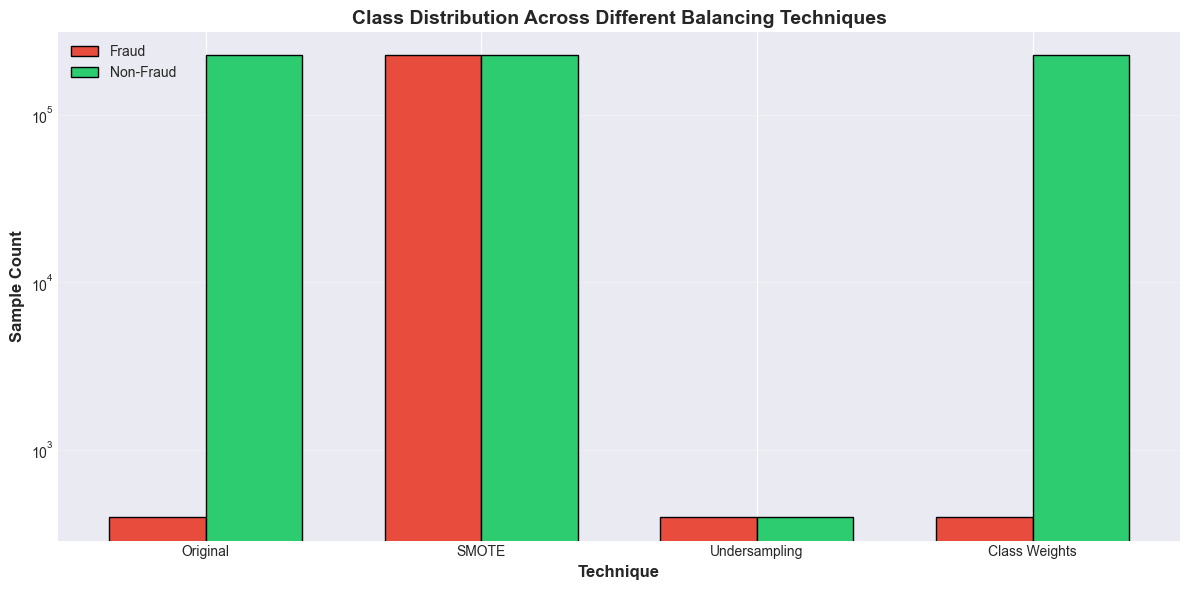

In [17]:
# Create comparison table
comparison_data = {
    'Technique': ['Original', 'SMOTE', 'Undersampling', 'Class Weights'],
    'Fraud Count': [
        (y_train == 1).sum(),
        (y_train_smote == 1).sum(),
        (y_train_rus == 1).sum(),
        (y_train == 1).sum()
    ],
    'Non-Fraud Count': [
        (y_train == 0).sum(),
        (y_train_smote == 0).sum(),
        (y_train_rus == 0).sum(),
        (y_train == 0).sum()
    ],
    'Total Size': [
        len(y_train),
        len(y_train_smote),
        len(y_train_rus),
        len(y_train)
    ],
    'Notes': [
        'Extremely imbalanced',
        'Balanced with synthetic data',
        'Balanced but small',
        'Original size, weighted loss'
    ]
}

comparison_df = pd.DataFrame(comparison_data)
print("\nImbalance Handling Techniques Comparison:")
print("="*80)
print(comparison_df.to_string(index=False))

# Visualize
fig, ax = plt.subplots(figsize=(12, 6))
x = np.arange(len(comparison_df))
width = 0.35

ax.bar(x - width/2, comparison_df['Fraud Count'], width, label='Fraud', color='#e74c3c', edgecolor='black')
ax.bar(x + width/2, comparison_df['Non-Fraud Count'], width, label='Non-Fraud', color='#2ecc71', edgecolor='black')

ax.set_xlabel('Technique', fontsize=12, fontweight='bold')
ax.set_ylabel('Sample Count', fontsize=12, fontweight='bold')
ax.set_title('Class Distribution Across Different Balancing Techniques', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(comparison_df['Technique'])
ax.legend()
ax.set_yscale('log')
ax.grid(alpha=0.3, axis='y')

plt.tight_layout()
plt.show()


# Model Training & Evaluation

In [18]:
# Dictionary to store results
results = {
    'Model': [],
    'Technique': [],
    'PR-AUC': [],
    'ROC-AUC': [],
    'Precision': [],
    'Recall': [],
    'F1-Score': []
}

def evaluate_model(model, X_train_data, y_train_data, X_test_data, y_test_data, model_name, technique):
    """Train model and compute evaluation metrics"""
    # Train
    model.fit(X_train_data, y_train_data)
    
    # Predict
    y_pred = model.predict(X_test_data)
    y_pred_proba = model.predict_proba(X_test_data)[:, 1] if hasattr(model, 'predict_proba') else model.decision_function(X_test_data)
    
    # Calculate metrics
    pr_auc = average_precision_score(y_test_data, y_pred_proba)
    roc_auc = roc_auc_score(y_test_data, y_pred_proba)
    
    from sklearn.metrics import precision_score, recall_score, f1_score
    precision = precision_score(y_test_data, y_pred)
    recall = recall_score(y_test_data, y_pred)
    f1 = f1_score(y_test_data, y_pred)
    
    # Store results
    results['Model'].append(model_name)
    results['Technique'].append(technique)
    results['PR-AUC'].append(pr_auc)
    results['ROC-AUC'].append(roc_auc)
    results['Precision'].append(precision)
    results['Recall'].append(recall)
    results['F1-Score'].append(f1)
    
    print(f"\n{'='*60}")
    print(f"{model_name} - {technique}")
    print(f"{'='*60}")
    print(f"PR-AUC: {pr_auc:.4f} | ROC-AUC: {roc_auc:.4f}")
    print(f"Precision: {precision:.4f} | Recall: {recall:.4f} | F1: {f1:.4f}")
    print(f"\nConfusion Matrix:")
    print(confusion_matrix(y_test_data, y_pred))
    
    return model, y_pred_proba

print("🚀 Starting model training...\n")

🚀 Starting model training...



## Logistic Regression (Class Weights)

In [19]:
# Logistic Regression with balanced class weights
lr_model, lr_proba = evaluate_model(
    LogisticRegression(class_weight='balanced', max_iter=1000, random_state=RANDOM_STATE),
    X_train, y_train, X_test, y_test,
    'Logistic Regression', 'Class Weights'
)


Logistic Regression - Class Weights
PR-AUC: 0.7175 | ROC-AUC: 0.9720
Precision: 0.0609 | Recall: 0.9184 | F1: 0.1142

Confusion Matrix:
[[55476  1388]
 [    8    90]]


## Random Forest (SMOTE)

In [20]:
# Random Forest with SMOTE
rf_model, rf_proba = evaluate_model(
    RandomForestClassifier(n_estimators=100, max_depth=10, random_state=RANDOM_STATE, n_jobs=-1),
    X_train_smote, y_train_smote, X_test, y_test,
    'Random Forest', 'SMOTE'
)


Random Forest - SMOTE
PR-AUC: 0.8173 | ROC-AUC: 0.9841
Precision: 0.4187 | Recall: 0.8673 | F1: 0.5648

Confusion Matrix:
[[56746   118]
 [   13    85]]


## LightGBM (SMOTE)

In [21]:
# LightGBM with SMOTE
lgbm_model, lgbm_proba = evaluate_model(
    LGBMClassifier(n_estimators=100, max_depth=6, learning_rate=0.1, random_state=RANDOM_STATE, verbosity=-1),
    X_train_smote, y_train_smote, X_test, y_test,
    'LightGBM', 'SMOTE'
)


LightGBM - SMOTE
PR-AUC: 0.8569 | ROC-AUC: 0.9761
Precision: 0.3221 | Recall: 0.8776 | F1: 0.4712

Confusion Matrix:
[[56683   181]
 [   12    86]]


# Isolation Forest (Anomaly Detection)

In [22]:
# Isolation Forest (unsupervised)
iso_forest = IsolationForest(contamination=0.002, random_state=RANDOM_STATE, n_jobs=-1)
iso_forest.fit(X_train)

# Predict (-1 for anomalies, 1 for normal)
y_pred_iso = iso_forest.predict(X_test)
y_pred_iso = np.where(y_pred_iso == -1, 1, 0)  # Convert to 0/1

# Anomaly scores (more negative = more anomalous)
y_scores_iso = -iso_forest.score_samples(X_test)

# Calculate metrics
from sklearn.metrics import precision_score, recall_score, f1_score
pr_auc_iso = average_precision_score(y_test, y_scores_iso)
roc_auc_iso = roc_auc_score(y_test, y_scores_iso)
precision_iso = precision_score(y_test, y_pred_iso)
recall_iso = recall_score(y_test, y_pred_iso)
f1_iso = f1_score(y_test, y_pred_iso)

results['Model'].append('Isolation Forest')
results['Technique'].append('Anomaly Detection')
results['PR-AUC'].append(pr_auc_iso)
results['ROC-AUC'].append(roc_auc_iso)
results['Precision'].append(precision_iso)
results['Recall'].append(recall_iso)
results['F1-Score'].append(f1_iso)

print(f"\n{'='*60}")
print(f"Isolation Forest - Anomaly Detection")
print(f"{'='*60}")
print(f"PR-AUC: {pr_auc_iso:.4f} | ROC-AUC: {roc_auc_iso:.4f}")
print(f"Precision: {precision_iso:.4f} | Recall: {recall_iso:.4f} | F1: {f1_iso:.4f}")
print(f"\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_iso))


Isolation Forest - Anomaly Detection
PR-AUC: 0.2180 | ROC-AUC: 0.9543
Precision: 0.2787 | Recall: 0.3469 | F1: 0.3091

Confusion Matrix:
[[56776    88]
 [   64    34]]


# Model Comparison & Selection

In [23]:
# Create results DataFrame
results_df = pd.DataFrame(results)
results_df = results_df.sort_values('PR-AUC', ascending=False).reset_index(drop=True)

print("\n" + "="*70)
print("MODEL COMPARISON - RANKED BY PR-AUC")
print("="*70)
print(results_df.to_string(index=False))
print("\n" + "="*70)
print(f"🏆 Best Model: {results_df.iloc[0]['Model']} with {results_df.iloc[0]['Technique']}")
print(f"   PR-AUC: {results_df.iloc[0]['PR-AUC']:.4f}")
print("="*70)


MODEL COMPARISON - RANKED BY PR-AUC
              Model         Technique   PR-AUC  ROC-AUC  Precision   Recall  F1-Score
           LightGBM             SMOTE 0.856886 0.976102   0.322097 0.877551  0.471233
      Random Forest             SMOTE 0.817268 0.984069   0.418719 0.867347  0.564784
Logistic Regression     Class Weights 0.717454 0.972045   0.060893 0.918367  0.114213
   Isolation Forest Anomaly Detection 0.217972 0.954336   0.278689 0.346939  0.309091

🏆 Best Model: LightGBM with SMOTE
   PR-AUC: 0.8569


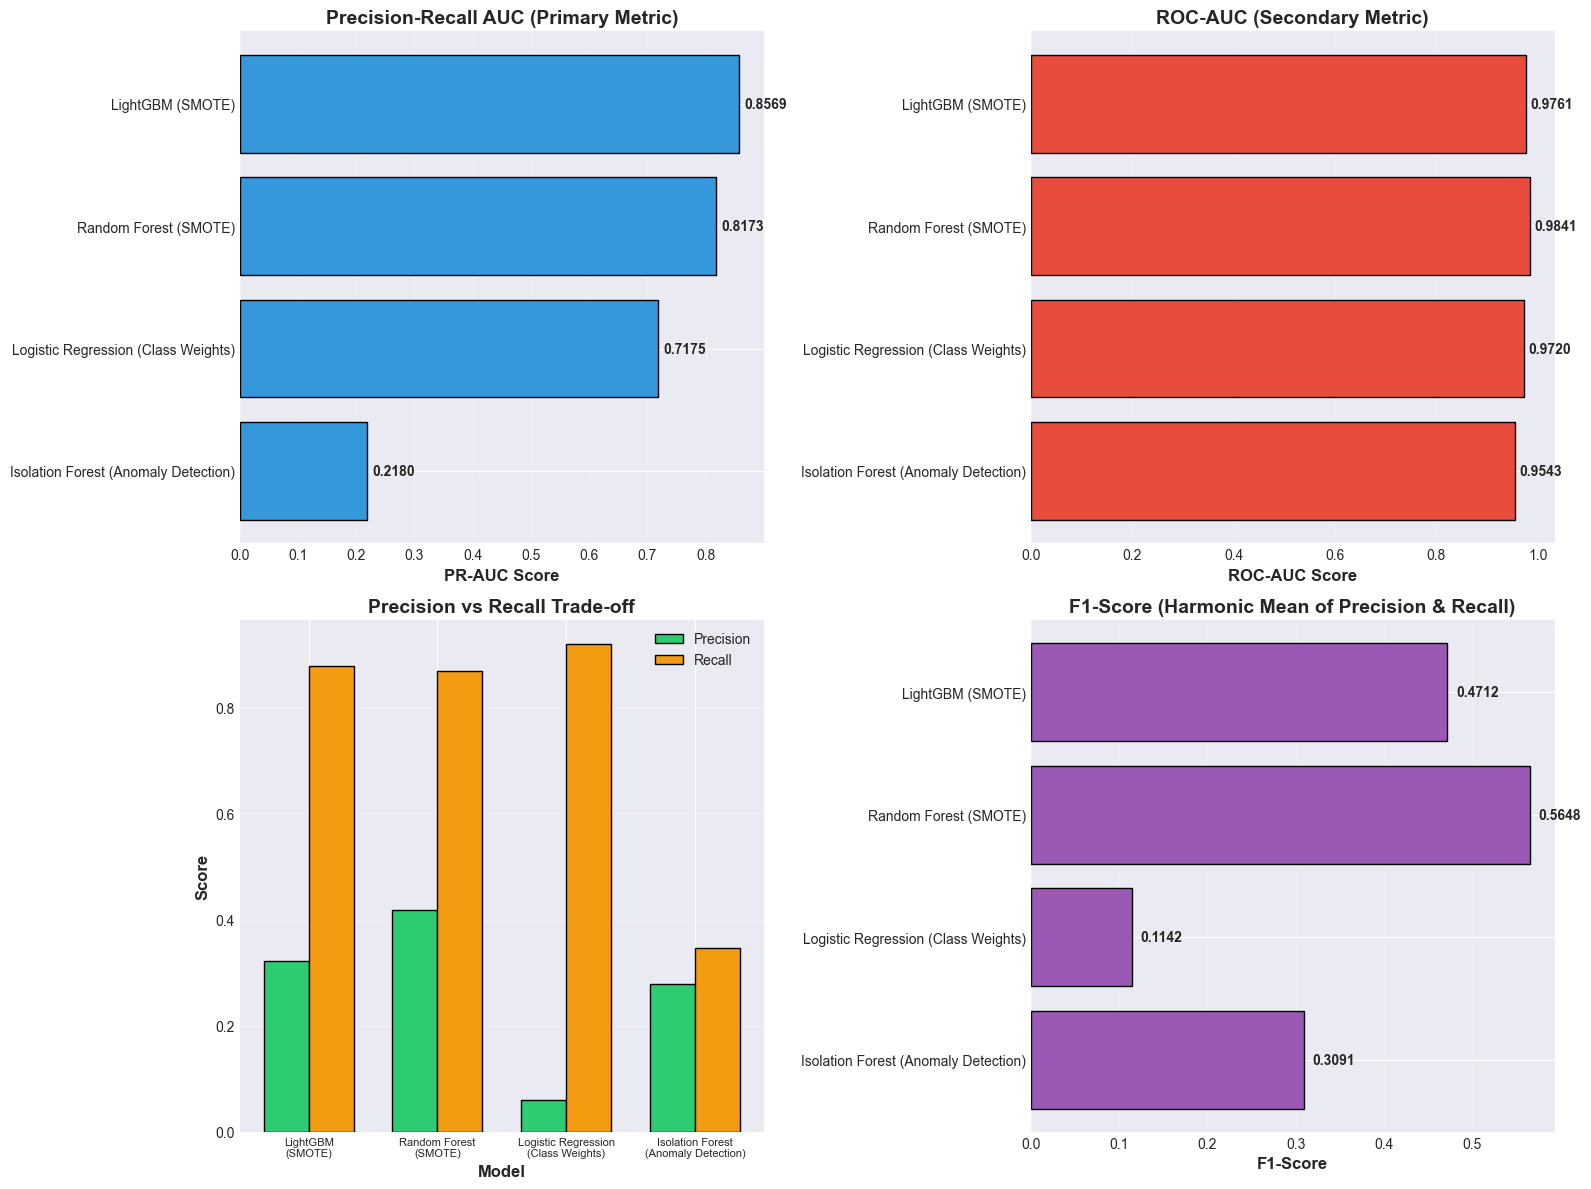

In [24]:
# Visualize comparison
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# PR-AUC comparison
axes[0, 0].barh(range(len(results_df)), results_df['PR-AUC'], color='#3498db', edgecolor='black')
axes[0, 0].set_yticks(range(len(results_df)))
axes[0, 0].set_yticklabels([f"{m} ({t})" for m, t in zip(results_df['Model'], results_df['Technique'])], fontsize=10)
axes[0, 0].set_xlabel('PR-AUC Score', fontsize=12, fontweight='bold')
axes[0, 0].set_title('Precision-Recall AUC (Primary Metric)', fontsize=14, fontweight='bold')
axes[0, 0].invert_yaxis()
axes[0, 0].grid(alpha=0.3, axis='x')
for i, v in enumerate(results_df['PR-AUC']):
    axes[0, 0].text(v + 0.01, i, f'{v:.4f}', va='center', fontweight='bold')

# ROC-AUC comparison
axes[0, 1].barh(range(len(results_df)), results_df['ROC-AUC'], color='#e74c3c', edgecolor='black')
axes[0, 1].set_yticks(range(len(results_df)))
axes[0, 1].set_yticklabels([f"{m} ({t})" for m, t in zip(results_df['Model'], results_df['Technique'])], fontsize=10)
axes[0, 1].set_xlabel('ROC-AUC Score', fontsize=12, fontweight='bold')
axes[0, 1].set_title('ROC-AUC (Secondary Metric)', fontsize=14, fontweight='bold')
axes[0, 1].invert_yaxis()
axes[0, 1].grid(alpha=0.3, axis='x')
for i, v in enumerate(results_df['ROC-AUC']):
    axes[0, 1].text(v + 0.01, i, f'{v:.4f}', va='center', fontweight='bold')

# Precision-Recall comparison
x = np.arange(len(results_df))
width = 0.35
axes[1, 0].bar(x - width/2, results_df['Precision'], width, label='Precision', color='#2ecc71', edgecolor='black')
axes[1, 0].bar(x + width/2, results_df['Recall'], width, label='Recall', color='#f39c12', edgecolor='black')
axes[1, 0].set_xlabel('Model', fontsize=12, fontweight='bold')
axes[1, 0].set_ylabel('Score', fontsize=12, fontweight='bold')
axes[1, 0].set_title('Precision vs Recall Trade-off', fontsize=14, fontweight='bold')
axes[1, 0].set_xticks(x)
axes[1, 0].set_xticklabels([f"{m}\n({t})" for m, t in zip(results_df['Model'], results_df['Technique'])], fontsize=8, rotation=0)
axes[1, 0].legend()
axes[1, 0].grid(alpha=0.3, axis='y')

# F1-Score comparison
axes[1, 1].barh(range(len(results_df)), results_df['F1-Score'], color='#9b59b6', edgecolor='black')
axes[1, 1].set_yticks(range(len(results_df)))
axes[1, 1].set_yticklabels([f"{m} ({t})" for m, t in zip(results_df['Model'], results_df['Technique'])], fontsize=10)
axes[1, 1].set_xlabel('F1-Score', fontsize=12, fontweight='bold')
axes[1, 1].set_title('F1-Score (Harmonic Mean of Precision & Recall)', fontsize=14, fontweight='bold')
axes[1, 1].invert_yaxis()
axes[1, 1].grid(alpha=0.3, axis='x')
for i, v in enumerate(results_df['F1-Score']):
    axes[1, 1].text(v + 0.01, i, f'{v:.4f}', va='center', fontweight='bold')

plt.tight_layout()
plt.show()


# Model Explainability with SHAP

In [25]:
# Select best tree-based model for SHAP analysis
best_tree_model = results_df[(results_df['Model'].isin(['Random Forest', 'XGBoost', 'LightGBM']))].iloc[0]
print(f"Analyzing: {best_tree_model['Model']} with {best_tree_model['Technique']}")

# Get the corresponding model
if 'Random Forest' in best_tree_model['Model']:
    model_for_shap = rf_model
elif 'XGBoost' in best_tree_model['Model']:
    model_for_shap = xgb_model
else:
    model_for_shap = lgbm_model

print("\n⏳ Computing SHAP values (this may take a minute)...")

Analyzing: LightGBM with SMOTE

⏳ Computing SHAP values (this may take a minute)...


In [26]:
# Create SHAP explainer (using stratified sample to ensure fraud cases included)
# Sample 1000 transactions with at least 20 fraud cases
fraud_cases = X_test[y_test == 1]
legitimate_cases = X_test[y_test == 0]

# Take all fraud cases if less than 20, otherwise sample 20
n_fraud_sample = min(20, len(fraud_cases))
fraud_sample = fraud_cases.sample(n=n_fraud_sample, random_state=RANDOM_STATE) if len(fraud_cases) > 0 else fraud_cases

# Sample legitimate cases to total 1000
n_legitimate_sample = min(980, len(legitimate_cases))
legitimate_sample = legitimate_cases.sample(n=n_legitimate_sample, random_state=RANDOM_STATE)

# Combine and shuffle
X_test_sample = pd.concat([fraud_sample, legitimate_sample]).sample(frac=1, random_state=RANDOM_STATE)

print(f"Sample composition: {len(fraud_sample)} fraud cases, {len(legitimate_sample)} legitimate cases")

explainer = shap.TreeExplainer(model_for_shap)
shap_values = explainer.shap_values(X_test_sample)

# For binary classification, get positive class SHAP values
if isinstance(shap_values, list):
    shap_values = shap_values[1]

print("✅ SHAP values computed successfully!")

Sample composition: 20 fraud cases, 980 legitimate cases
✅ SHAP values computed successfully!


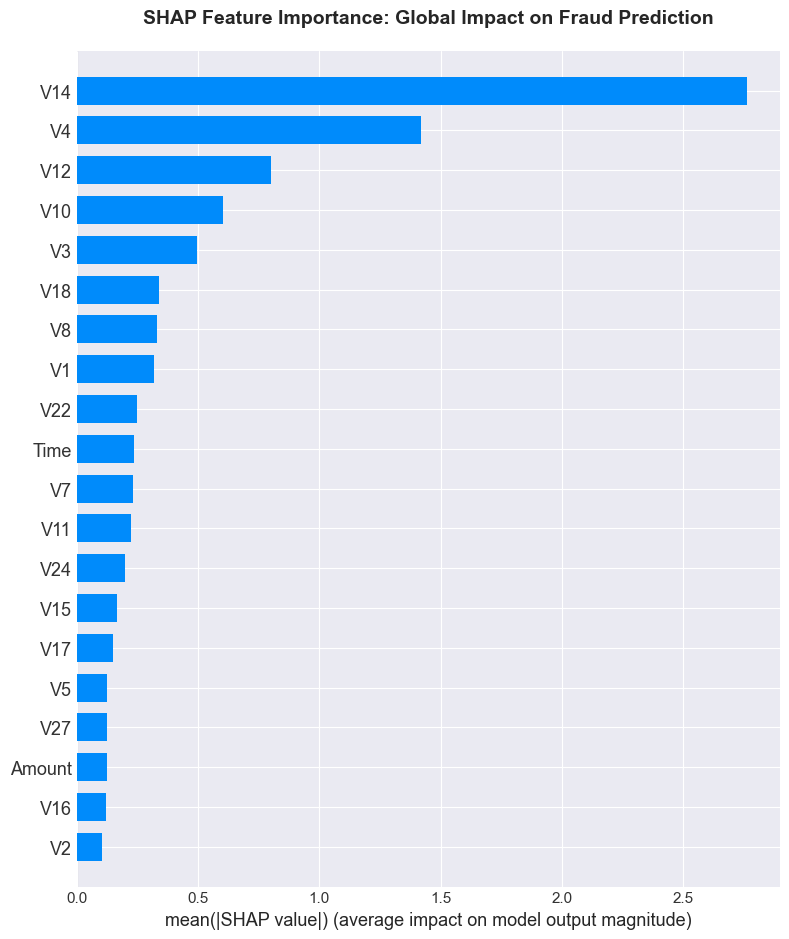


💡 Interpretation: Features at the top have the highest average impact on model predictions.
   Even though V1-V28 are PCA components, SHAP reveals their relative importance.


In [27]:
# SHAP summary plot (global feature importance)
plt.figure(figsize=(10, 8))
shap.summary_plot(shap_values, X_test_sample, plot_type="bar", show=False)
plt.title('SHAP Feature Importance: Global Impact on Fraud Prediction', fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

print("\n💡 Interpretation: Features at the top have the highest average impact on model predictions.")
print("   Even though V1-V28 are PCA components, SHAP reveals their relative importance.")

## Feature Impact Distribution

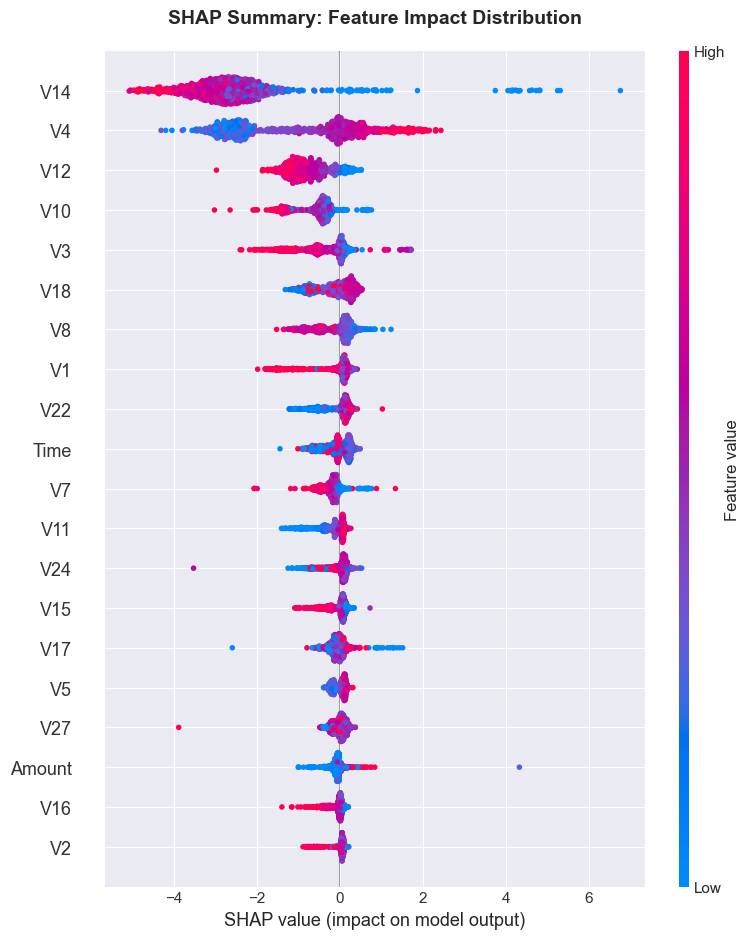


💡 Interpretation:
   - Each dot is a transaction
   - Color indicates feature value (red=high, blue=low)
   - Position shows impact on prediction (right=increases fraud probability)
   - This reveals complex relationships between features and fraud likelihood


In [28]:
# SHAP summary plot (shows feature impact distribution)
plt.figure(figsize=(10, 10))
shap.summary_plot(shap_values, X_test_sample, show=False)
plt.title('SHAP Summary: Feature Impact Distribution', fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

print("\n💡 Interpretation:")
print("   - Each dot is a transaction")
print("   - Color indicates feature value (red=high, blue=low)")
print("   - Position shows impact on prediction (right=increases fraud probability)")
print("   - This reveals complex relationships between features and fraud likelihood")

## Individual Prediction Explanation


🔍 Explaining a specific fraud case (index: 6108):

SHAP Force Plot:


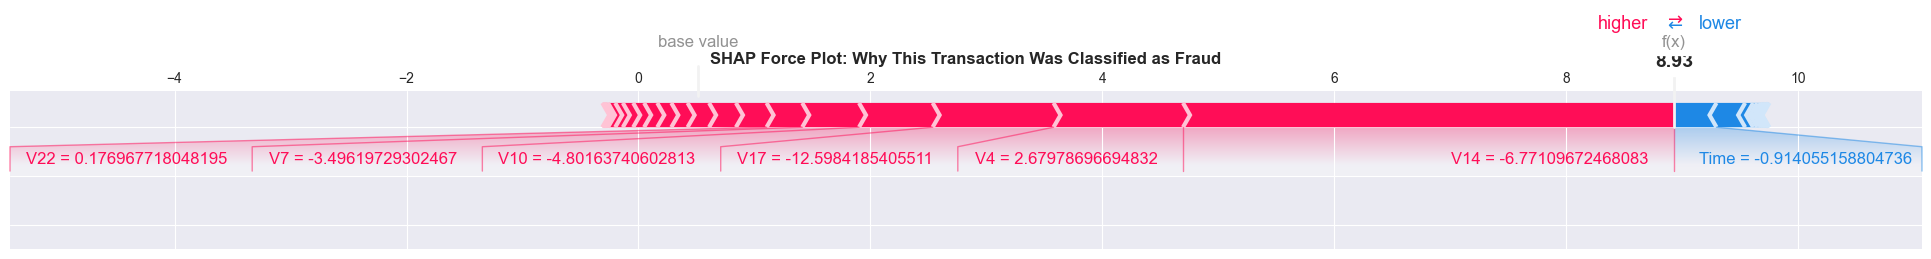


💡 Interpretation:
   - Base value: Average model prediction
   - Red features push prediction toward fraud
   - Blue features push prediction toward legitimate
   - Final prediction: Where the arrow points


In [29]:
# Find a fraud case to explain
fraud_indices = y_test[y_test == 1].index
fraud_idx_in_sample = X_test_sample.index.intersection(fraud_indices)

if len(fraud_idx_in_sample) > 0:
    fraud_case_idx = 0
    fraud_case = X_test_sample.loc[fraud_idx_in_sample[fraud_case_idx]]
    fraud_case_position = X_test_sample.index.get_loc(fraud_idx_in_sample[fraud_case_idx])
    
    # Handle both old and new SHAP versions
    base_value = explainer.expected_value
    if hasattr(base_value, '__len__') and not isinstance(base_value, str):
        base_value = base_value[0] if len(base_value) == 1 else base_value[1]
    
    # Force plot for this fraud case
    print(f"\n🔍 Explaining a specific fraud case (index: {fraud_idx_in_sample[fraud_case_idx]}):")
    print("\nSHAP Force Plot:")
    shap.force_plot(base_value, shap_values[fraud_case_position], fraud_case, matplotlib=True, show=False)
    plt.title('SHAP Force Plot: Why This Transaction Was Classified as Fraud', fontsize=12, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    print("\n💡 Interpretation:")
    print("   - Base value: Average model prediction")
    print("   - Red features push prediction toward fraud")
    print("   - Blue features push prediction toward legitimate")
    print("   - Final prediction: Where the arrow points")
else:
    print("No fraud cases in sample - increasing sample size...")

## Threshold Tuning

In [30]:
# Use best model for threshold tuning
best_model_name = results_df.iloc[0]['Model']

if 'Random Forest' in best_model_name:
    best_proba = rf_proba
elif 'XGBoost' in best_model_name:
    best_proba = xgb_proba
elif 'LightGBM' in best_model_name:
    best_proba = lgbm_proba
else:
    best_proba = lr_proba

# Calculate precision-recall curve
precision_vals, recall_vals, thresholds = precision_recall_curve(y_test, best_proba)

# Calculate F2-score (weighs recall higher than precision)
f2_scores = (5 * precision_vals * recall_vals) / (4 * precision_vals + recall_vals + 1e-10)

# Find optimal thresholds
optimal_f2_idx = np.argmax(f2_scores[:-1])
optimal_f2_threshold = thresholds[optimal_f2_idx]

print(f"Optimal Threshold (F2-Score): {optimal_f2_threshold:.4f}")
print(f"  Precision: {precision_vals[optimal_f2_idx]:.4f}")
print(f"  Recall: {recall_vals[optimal_f2_idx]:.4f}")
print(f"  F2-Score: {f2_scores[optimal_f2_idx]:.4f}")

Optimal Threshold (F2-Score): 0.9582
  Precision: 0.9000
  Recall: 0.8265
  F2-Score: 0.8402


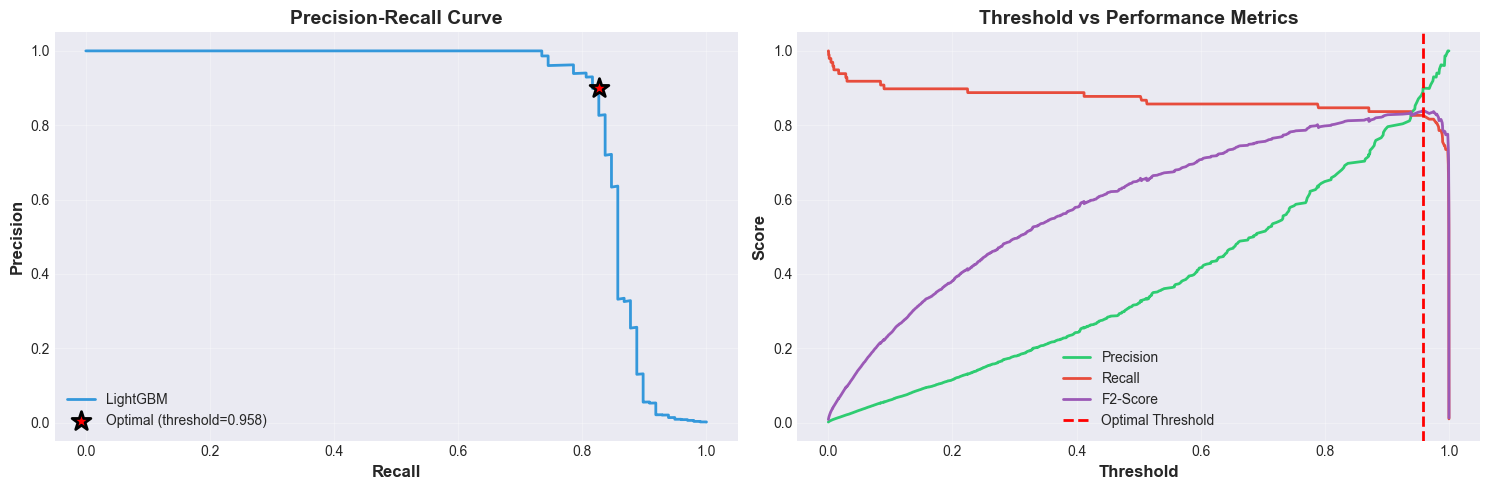


💡 Insight: Threshold tuning allows us to balance false positives vs false negatives.
   In production, choose threshold based on business cost of each error type.


In [31]:
# Visualize precision-recall trade-off
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Precision-Recall curve
axes[0].plot(recall_vals, precision_vals, linewidth=2, color='#3498db', label=f'{best_model_name}')
axes[0].scatter(recall_vals[optimal_f2_idx], precision_vals[optimal_f2_idx], 
                color='red', s=200, zorder=5, marker='*', edgecolor='black', linewidth=2,
                label=f'Optimal (threshold={optimal_f2_threshold:.3f})')
axes[0].set_xlabel('Recall', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Precision', fontsize=12, fontweight='bold')
axes[0].set_title('Precision-Recall Curve', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Threshold vs Metrics
axes[1].plot(thresholds, precision_vals[:-1], label='Precision', linewidth=2, color='#2ecc71')
axes[1].plot(thresholds, recall_vals[:-1], label='Recall', linewidth=2, color='#e74c3c')
axes[1].plot(thresholds, f2_scores[:-1], label='F2-Score', linewidth=2, color='#9b59b6')
axes[1].axvline(optimal_f2_threshold, color='red', linestyle='--', linewidth=2, label='Optimal Threshold')
axes[1].set_xlabel('Threshold', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Score', fontsize=12, fontweight='bold')
axes[1].set_title('Threshold vs Performance Metrics', fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("\n💡 Insight: Threshold tuning allows us to balance false positives vs false negatives.")
print("   In production, choose threshold based on business cost of each error type.")
